Author: Parveen Gartan \
Place:  AstraZeneca, Gothenburg \
Date:   12 Dec 2023 

In [1]:
import lomap
import networkx as nx

import os, sys, glob, subprocess
import math
import numpy as np
import matplotlib.pyplot as plt

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Recap,BRICS
from rdkit import DataStructs
from rdkit import RDLogger
from rdkit.Chem import rdMolAlign

p = AllChem.ETKDGv2()
p.verbose = False

import openfe
from openfe import SmallMoleculeComponent

Limitations:
1. Charged perturbations
2. Fused ring breaking or size changing example systems (ERa,)
3. 

Required inputs:
1. input directory containing the sdf files for LOMAP netowrk generation
2. Reference molecule that will be used for alignment (required)


Output directories or files: \
a. frags : fragments from RDKit \
b. fromLomap : Lomap edges with good scores, aligned to a given reference structure. \
c. forOpenfe : Lomap edges with bad scores and their fragments, all aligned to a given reference structure.


In [2]:
## load all the sdf files and generate lomap network

db_mol = lomap.DBMolecules("000/", output=True, name='p38')
strict, loose = db_mol.build_matrices()
nx_graph = db_mol.build_graph()

In [3]:
## get edges whose score is less than cutoff
lomap_cutoff = 0.4 ## I defined this cutoff to filter out bad edges from lomap graph

for_frag = [] ## these molecules will be fragmented later on with RDKit
for_frag.clear()
for edge in nx_graph.edges(data=True):
    score = nx_graph.edges[[edge[0], edge[1]]]['similarity']
    if score > lomap_cutoff:
        print('transformation: ' + str(nx_graph.nodes[edge[0]]['fname_comp']) + ' <--> ' + str(nx_graph.nodes[edge[1]]['fname_comp']))
    else:
        for_frag.append(nx_graph.nodes[edge[0]]['fname_comp'])
        for_frag.append(nx_graph.nodes[edge[1]]['fname_comp'])
        #print('Fragmentation required: ' + str(nx_graph.nodes[edge[0]]['fname_comp']) + ' <--> ' + str(nx_graph.nodes[edge[1]]['fname_comp']))


transformation: lig_p38a_2aa.sdf <--> lig_p38a_3flw.sdf
transformation: lig_p38a_2aa.sdf <--> lig_p38a_3fly.sdf
transformation: lig_p38a_2bb.sdf <--> lig_p38a_3fly.sdf
transformation: lig_p38a_2bb.sdf <--> lig_p38a_3flq.sdf
transformation: lig_p38a_3fmk.sdf <--> lig_p38a_3fmh.sdf
transformation: lig_p38a_3fmk.sdf <--> lig_p38a_3fly.sdf
transformation: lig_p38a_2v.sdf <--> lig_p38a_2z.sdf
transformation: lig_p38a_2v.sdf <--> lig_p38a_3fly.sdf
transformation: lig_p38a_2y.sdf <--> lig_p38a_2z.sdf
transformation: lig_p38a_2y.sdf <--> lig_p38a_3fly.sdf
transformation: lig_p38a_3flq.sdf <--> lig_p38a_3fly.sdf
transformation: lig_p38a_3flw.sdf <--> lig_p38a_3fly.sdf
transformation: lig_p38a_3fly.sdf <--> lig_p38a_3fmh.sdf
transformation: lig_p38a_2e.sdf <--> lig_p38a_3fln.sdf
transformation: lig_p38a_2e.sdf <--> lig_p38a_3flz.sdf
transformation: lig_p38a_2ee.sdf <--> lig_p38a_2j.sdf
transformation: lig_p38a_2ee.sdf <--> lig_p38a_3fln.sdf
transformation: lig_p38a_2f.sdf <--> lig_p38a_2g.sdf
tr

In [4]:
## generate a directory to store fragments:
os.makedirs('frags', exist_ok=True)

## get unique molecules from edges which have low lomap scores
molecules = []
molecules.clear()
for m in range(len(list(set(for_frag)))):
    tmp = Chem.SDMolSupplier(f'000/{list(set(for_frag))[m]}', removeHs=False)
    smi = Chem.MolToSmiles(tmp[0])
    mol = Chem.MolFromSmiles(smi)
    molecules.append(mol)

In [5]:
## 2. ------------------------------------------
# generate dummy atom
du = Chem.MolFromSmiles('*')

all_smiles = []
all_smiles.clear()

##************************
## suppress rdkit warnings
RDLogger.DisableLog('rdApp.*')
##************************

## fragmenting using BRICSDecompose
for mol in molecules:
    frags = list(Chem.BRICS.BRICSDecompose(mol, minFragmentSize=1, keepNonLeafNodes=True, returnMols=False))
    ##if returnMols = False
    mols = [Chem.MolFromSmiles(x) for x in frags]
    ## replace dummy atoms with hydrogens
    molh = [AllChem.ReplaceSubstructs(x,du,Chem.MolFromSmiles('[H]'), True)[0] for x in mols]
    ## convert mols to smiles
    all_smiles.append([Chem.MolToSmiles(x) for x in molh])


##***************************
## enable default rdkit warnings again
RDLogger.EnableLog('rdApp.info')
##****************************


In [6]:
## 3. -----------------------------------------------------

## save fragments using similarity as a filter
## tanimoto similarity cut-off  = 0.35 (arbitrary)
## or Dice threshold = 0.45
## the cut-offs are somewhat arbitrary for now.
x = 1
y = 1

## Different parent might generate same fragments so,
fps = [] ## save all fragment's fingerprint to filter duplicate fragments from different parents
fps.clear()

cutoff = 0.30  ## arbitrary similarity cutoff, fragments with lower similarity than this won't be saved.

##  all_smiles is a list of list so, need to use a nested loop
for i in all_smiles:
    ref   = molecules[all_smiles.index(i)] ## similarity wrt reference parent molecule
    fp_r  = Chem.RDKFingerprint(ref)
    #fps.append(fp_r)
    for smi in i:
        mol   = Chem.MolFromSmiles(smi)
        query = mol
        mol   = Chem.AddHs(mol)        
        fp_q  = Chem.RDKFingerprint(query)
        sim   = DataStructs.TanimotoSimilarity(fp_r,fp_q)
        #print(f'similarity = {sim}, reference sdf index = {all_smiles.index(i)}')
        #print('========')
        if cutoff < round(sim,1) < 0.9: ## it means it's a fragment
            ## check whether we have a similar fragment from another parent
            frag_fps = []
            frag_fps.clear()
            for fp in range(len(fps)):
                frag_fps.append(DataStructs.TanimotoSimilarity(fps[fp], fp_q))
            if any(z==1 for z in frag_fps):
                x+=0
            else:
                fps.append(fp_q)
                ## save fragment molecules             
                with Chem.SDWriter('frags/tmp_' + str(y) + '_' +str(x) + '.sdf') as writer:
                    ## settings names in the output sdf file
                    ## important for OpenFE, nodes are referred to as their names in the sdf files not the sdf_file_name
                    mol.SetProp('_Name', 'tmp_' + str(y) + '_' + str(x)) 
                    mol.SetProp('ID', 'tmp_' + str(y) + '_' + str(x))
                    confIds = Chem.AllChem.EmbedMultipleConfs(mol, 1)
                    for confId in range(1):
                        Chem.AllChem.UFFOptimizeMolecule(mol, confId=confId)
                        writer.write(mol, confId=confId)
                        x += 1
        else:
            x += 0
    y +=1
    x = 1

## file name: tmp_y_x.sdf
## y = parent, x = fragment

In [8]:
## generate and align 3D structures of the edges with good lomap scores

##***************************************
## open a reference sturcture upon which others will be aligned
## preserving input coordinates (must be 3D structure data file)
ref1 = Chem.SDMolSupplier('000/lig_p38a_2aa.sdf', removeHs=False)
for ref in ref1:
    #ref1_smi = Chem.MolToSmiles(ref)
    #ref1_mol = Chem.MolFromSmiles(ref1_smi)
    ref1_molh = ref #Chem.AddHs(ref1_mol)

AllChem.EmbedMultipleConfs(ref1_molh, 1)

## get MMFF parameters for the reference molecule
mmff_ref_param = AllChem.MMFFGetMoleculeProperties(ref1_molh)
ref_mol2 = ref1_molh
##*************************************

Open3DAlign notes: (https://www.mail-archive.com/rdkit-discuss@lists.sourceforge.net/msg09636.html)

O3A.Align() returns the RMSD between the atom pairs that the O3A
algorithm was able to match across the two molecules.

O3A.Score() returns the score for an alignment. The score is directly
proportional to:

* the number of atom pairs that could be matched across the two molecules
* the closeness of the match (i.e., how similar actually the atoms in the
  matched pair are)

In [10]:
## LOMAP edges ====>>
## write out one aligned (to a given reference) sdf files for each lomap edge with good score.
## These can then be directly used with OpenFE.
## change the reference molecule if you're not satisfied with the alignment (RMSD).

os.makedirs('fromLomap', exist_ok=True)

for edge in nx_graph.edges(data=True):
    score = nx_graph.edges[[edge[0], edge[1]]]['similarity']
    if score > lomap_cutoff:
        print('transformation: ' + str(nx_graph.nodes[edge[0]]['fname_comp']) + ' <--> ' + str(nx_graph.nodes[edge[1]]['fname_comp']))
        
        mol1 = Chem.SDMolSupplier('000/'+str(nx_graph.nodes[edge[0]]['fname_comp']), removeHs=False)
        mol2 = Chem.SDMolSupplier('000/'+str(nx_graph.nodes[edge[1]]['fname_comp']), removeHs=False)
        
        sdfs = [mol1, mol2]
        molecules = []
        molecules.clear()
        for sdf in sdfs:
            smi = [Chem.MolToSmiles(x) for x in sdf]
            mol = [Chem.MolFromSmiles(x) for x in smi]
            molecules.append(Chem.AddHs(mol[0]))

        confs = 100 ## number of conformers to generate
        print(f'Generating {confs} conformers for each molecule')
        for mol in molecules[0:]:
            AllChem.EmbedMultipleConfs(mol, confs, p)

        ## get MMFF parameters for each molecule
        mmff_params = [AllChem.MMFFGetMoleculeProperties(mol) for mol in molecules]
        #mmff_ref_param = mmff_params[0]
        mmff_prob_params = mmff_params[0:]
        #ref_mol2 = molecules[0]
        prob_mols_2 = molecules[0:]


        ## perform alignment and save the best scored conformer
        print('Performing alignment and saving the conformer with best score only.')

        with Chem.SDWriter('fromLomap/' +str(nx_graph.nodes[edge[0]]['fname_comp']) +'_' + str(nx_graph.nodes[edge[1]]['fname_comp'])) as writer:
            #writer.write(ref_mol2) ## save the reference if you want to look at the alignment
            pyO3A_score = []
            rmsd = []
            for idx, mol in enumerate(prob_mols_2):
                tempscore = []
                temprmsd = []
                for cid in range(confs):
                    pyO3A = rdMolAlign.GetO3A(mol, ref_mol2, mmff_prob_params[idx], mmff_ref_param, cid, 0)
                    temprmsd.append(pyO3A.Align())
                    tempscore.append(pyO3A.Score())
                best = np.argmax(tempscore)
                rmsd.append(temprmsd[best])
                ## save sdf file
                ## write names, to be used with network in openFE
                mol.SetProp('_Name', str(nx_graph.nodes[edge[prob_mols_2.index(mol)]]['fname_comp']))
                mol.SetProp('ID', str(int(best)))
                mol.SetProp('Open3D alignment rmsd wrt reference: ', str(round(rmsd[idx], 4)))
                writer.write(mol, confId=int(best))
                pyO3A_score.append(tempscore[best])
                #print('rmsd of best(saved) conformer wrt reference: ' + str(round(rmsd[idx], 4)))
                
                
        
        #print('pyO3A_score: ' + str(pyO3A_score))
        print('===================================')

print('Finished LOMAP edges. Next step OpenFE')

transformation: lig_p38a_2aa.sdf <--> lig_p38a_3flw.sdf
Generating 100 conformers for each molecule
Performing alignment and saving the conformer with best score only.
transformation: lig_p38a_2aa.sdf <--> lig_p38a_3fly.sdf
Generating 100 conformers for each molecule
Performing alignment and saving the conformer with best score only.
transformation: lig_p38a_2bb.sdf <--> lig_p38a_3fly.sdf
Generating 100 conformers for each molecule
Performing alignment and saving the conformer with best score only.
transformation: lig_p38a_2bb.sdf <--> lig_p38a_3flq.sdf
Generating 100 conformers for each molecule
Performing alignment and saving the conformer with best score only.
transformation: lig_p38a_3fmk.sdf <--> lig_p38a_3fmh.sdf
Generating 100 conformers for each molecule
Performing alignment and saving the conformer with best score only.
transformation: lig_p38a_3fmk.sdf <--> lig_p38a_3fly.sdf
Generating 100 conformers for each molecule
Performing alignment and saving the conformer with best sc

In [11]:
## openFE requires 3D sdf files and also they need to be aligned
## align fragments and their parent molecules to the same reference and save as individual sdf file

os.makedirs('forOpenfe', exist_ok=True)

file_names = []
sdfs = []
sdfs.clear()
for edge in nx_graph.edges(data=True):
    score = nx_graph.edges[[edge[0], edge[1]]]['similarity']
    if score < lomap_cutoff:
        print('poor edge: ' + str(nx_graph.nodes[edge[0]]['fname_comp']) + ' <--> ' + str(nx_graph.nodes[edge[1]]['fname_comp']))
        
        for i in range(2):  ## the length of an edge is 2.
            if str(nx_graph.nodes[edge[i]]['fname_comp']) not in file_names[0:]:
                file_names.append(str(nx_graph.nodes[edge[i]]['fname_comp']))
                sdfs.append(Chem.SDMolSupplier('000/'+str(nx_graph.nodes[edge[i]]['fname_comp']), removeHs=False))

if not sdfs:
    print("No bad edges found")
    print("OpenFE network generation is not required.")
    print("Finished, go for RBFE with LOMAP network only.")
    quit()

for f in glob.glob("frags/*.sdf"):
    sdf = Chem.SDMolSupplier(f, removeHs=False)
    sdfs.append(sdf)
    file_names.append(str(f[6:]))

#print(file_names)
print(f'------------------------------')

molecules = []
molecules.clear()
for sdf in sdfs:
    smi = [Chem.MolToSmiles(x) for x in sdf]
    mol = [Chem.MolFromSmiles(x) for x in smi]
    molecules.append(Chem.AddHs(mol[0]))

confs = 100 ## number of conformers to generate
print(f'Generating {confs} conformers for each molecule')
for mol in molecules[0:]:
    AllChem.EmbedMultipleConfs(mol, confs, p)

## get MMFF parameters for each molecule
mmff_params = [AllChem.MMFFGetMoleculeProperties(mol) for mol in molecules]
#mmff_ref_param = mmff_params[0]
mmff_prob_params = mmff_params[0:]
#ref_mol2 = molecules[0]
prob_mols_2 = molecules[0:]


## perform alignment and save the best scored conformer
print('Performing alignment and saving the conformer with best score only.')

#with Chem.SDWriter(f'forOpenfe/.sdf') as writer:
    #writer.write(ref_mol2)

pyO3A_score = []
rmsd = []
for idx, mol in enumerate(prob_mols_2):   
    tempscore = []
    temprmsd = []
    for cid in range(confs):
        pyO3A = rdMolAlign.GetO3A(mol, ref_mol2, mmff_prob_params[idx], mmff_ref_param, cid, 0)
        #pyO3A.Align()
        temprmsd.append(pyO3A.Align())
        tempscore.append(pyO3A.Score())
    best = np.argmax(tempscore)
    rmsd.append(temprmsd[best])
    ## save sdf file
    print(f'writing sdf file: {file_names[prob_mols_2.index(mol)]}')
    with Chem.SDWriter(f'forOpenfe/{file_names[prob_mols_2.index(mol)]}') as writer:
        #writer.write(ref_mol2) ## save the reference if you want to look at the alignment
        ## write names, to be used with network in openFE
        mol.SetProp('_Name', str(file_names[prob_mols_2.index(mol)]))
        mol.SetProp('ID', str(int(best)))
        mol.SetProp('Open3D alignment rmsd wrt reference: ', str(round(rmsd[idx], 4)))
        writer.write(mol, confId=int(best))
        
    #print('rmsd of best(saved) conformer wrt reference: ' + str(round(rmsd[idx], 4)))
    pyO3A_score.append(tempscore[best])

#print('pyO3A_score: ' + str(pyO3A_score))

print('Finished with aligned file, go to OpenFE for network generation.')
        

poor edge: lig_p38a_2v.sdf <--> lig_p38a_2x.sdf
poor edge: lig_p38a_2v.sdf <--> lig_p38a_3fln.sdf
poor edge: lig_p38a_2v.sdf <--> lig_p38a_2j.sdf
poor edge: lig_p38a_3fly.sdf <--> lig_p38a_2x.sdf
poor edge: lig_p38a_2c.sdf <--> lig_p38a_3flz.sdf
poor edge: lig_p38a_2c.sdf <--> lig_p38a_2e.sdf
------------------------------
Generating 100 conformers for each molecule
Performing alignment and saving the conformer with best score only.
writing sdf file: lig_p38a_2v.sdf
writing sdf file: lig_p38a_2x.sdf
writing sdf file: lig_p38a_3fln.sdf
writing sdf file: lig_p38a_2j.sdf
writing sdf file: lig_p38a_3fly.sdf
writing sdf file: lig_p38a_2c.sdf
writing sdf file: lig_p38a_3flz.sdf
writing sdf file: lig_p38a_2e.sdf
writing sdf file: tmp_1_1.sdf
writing sdf file: tmp_1_2.sdf
writing sdf file: tmp_1_3.sdf
writing sdf file: tmp_1_4.sdf
writing sdf file: tmp_1_5.sdf
writing sdf file: tmp_1_6.sdf
writing sdf file: tmp_2_1.sdf
writing sdf file: tmp_2_2.sdf
writing sdf file: tmp_2_3.sdf
writing sdf fil

In [12]:
## openFE maximal_netwok

sdfs = []
for f in glob.glob('forOpenfe/*.sdf'):
    sdf = Chem.SDMolSupplier(f, removeHs=False)
    sdfs.append(sdf[0])

ligands = [SmallMoleculeComponent(sdf) for sdf in sdfs]

mapper = openfe.LomapAtomMapper(max3d=100.0, element_change=True)
scorer = openfe.lomap_scorers.default_lomap_score
network_planner = openfe.ligand_network_planning.generate_maximal_network


In [13]:
ligand_network = network_planner(
ligands=ligands[0:],
     mappers=[mapper],
     scorer=scorer
)

 15%|#5        | 76/496 [00:01<00:08, 50.49it/s]

In [14]:
## openFE network is a frozen set and, I am not sure how to work with that. so,
## I create a new graph and we can now do wahtever we want to this graph.
## The new graph contains node names and lomap scores from the OpenFE network.

G = nx.Graph()

## low lomap score == considered as good edge weight by networkx or netowrkx edges are closer
## high lomap score == considered as bad edge weight by networkx or networkx edges are further 

for edge in ligand_network.edges:
    try:
        G.add_edge(edge.componentA.name, edge.componentB.name, weight=round(-math.log(edge.annotations['score']), 4), lomap_score=round(edge.annotations['score'], 4))
    except ValueError: ## if the edge score is zero, assign a high score (here randomly I chose 5)
        G.add_edge(edge.componentA.name, edge.componentB.name, weight=5, lomap_score=round(edge.annotations['score'], 4))

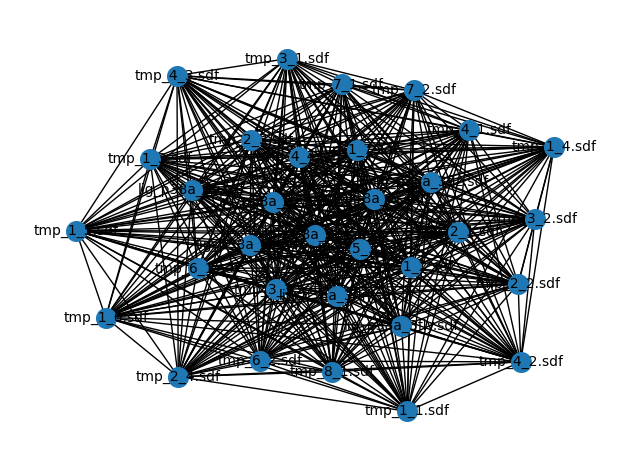

In [15]:
## ---------- plotting (not necessary at least for a maximal network) ------------------

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

## nodes
nx.draw_networkx_nodes(G, pos, node_size=200)

## edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1)

## node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

## edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [16]:
## from LOMAP network get poor edges since those are the edges that we are interseted in.
## for each edge, define one node as source and the other as target.
## Then we can find all paths (within a cutoff) connecting the source and target from the OpenFE maximal network.
## From all the paths, we can then define a shortest path which connects the source and target and also has good lomap scores along the way.
## Similarity scores were converted to edge weights in graph G as: W = -log(similarity)
## Function to find the shortest path = minimum{[(-logW1) + (-logW2) + .... + (-logWn) ]/n} where, n = number of edges

for edge in nx_graph.edges(data=True): 
    score = nx_graph.edges[[edge[0], edge[1]]]['similarity']
    if score < lomap_cutoff:
        source = nx_graph.nodes[edge[0]]['fname_comp']
        target = nx_graph.nodes[edge[1]]['fname_comp']
        
        os.makedirs(f'{source}_{target}', exist_ok=True)

        all_paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=3)) ##
        
        score = []
        score.clear()
        final_path = []
        final_path.clear()
        for path in range(len(all_paths)):
            #print(all_paths[path])
            pathGraph = nx.path_graph(all_paths[path])
            final_path.append(pathGraph)
            weights = []
            weights.clear()
            for ea in pathGraph.edges():
                weights.append(G.edges[ea[0], ea[1]]['weight'])
            
            score.append(round(sum(weights) / pathGraph.number_of_edges(), 4))
            #print('final score: ' + str(round(sum(weights) / pathGraph.number_of_edges(), 4)))

        print(f'{source}, {target}, score: {min(score, key=abs)}, {final_path[score.index(min(score, key=abs))]}')
        
        for ea in final_path[score.index(min(score, key=abs))].edges(data=True):
            if G.edges[ea[0], ea[1]]['lomap_score'] < 0.2:
                print(ea[0], '<-->', ea[1], '=> LOMAP score', G.edges[ea[0], ea[1]]['lomap_score'], '**poor edge**')
            else:
                print(ea[0], '<-->', ea[1], '=> LOMAP score', G.edges[ea[0], ea[1]]['lomap_score'])
            file_write = 'cat forOpenfe/' + str(ea[0]) + ' forOpenfe/' + str(ea[1]) + ' > ' + str(source)+'_'+str(target)+'/'+str(ea[0]) + '_' + str(ea[1])
            subprocess.check_call(file_write, shell=True)
        print('===================')
            

lig_p38a_2v.sdf, lig_p38a_2x.sdf, score: 0.3, Graph with 4 nodes and 3 edges
lig_p38a_2v.sdf <--> tmp_4_1.sdf => LOMAP score 0.7788
tmp_4_1.sdf <--> tmp_1_3.sdf => LOMAP score 0.9512
tmp_1_3.sdf <--> lig_p38a_2x.sdf => LOMAP score 0.5488
lig_p38a_2v.sdf, lig_p38a_3fln.sdf, score: 0.3333, Graph with 4 nodes and 3 edges
lig_p38a_2v.sdf <--> tmp_4_1.sdf => LOMAP score 0.7788
tmp_4_1.sdf <--> lig_p38a_2j.sdf => LOMAP score 0.4966
lig_p38a_2j.sdf <--> lig_p38a_3fln.sdf => LOMAP score 0.9512
lig_p38a_2v.sdf, lig_p38a_2j.sdf, score: 0.3167, Graph with 4 nodes and 3 edges
lig_p38a_2v.sdf <--> tmp_1_3.sdf => LOMAP score 0.8187
tmp_1_3.sdf <--> lig_p38a_3fln.sdf => LOMAP score 0.4966
lig_p38a_3fln.sdf <--> lig_p38a_2j.sdf => LOMAP score 0.9512
lig_p38a_3fly.sdf, lig_p38a_2x.sdf, score: 0.3333, Graph with 4 nodes and 3 edges
lig_p38a_3fly.sdf <--> lig_p38a_2v.sdf => LOMAP score 0.8187
lig_p38a_2v.sdf <--> tmp_1_3.sdf => LOMAP score 0.8187
tmp_1_3.sdf <--> lig_p38a_2x.sdf => LOMAP score 0.5488
lig

In [43]:
##------------Finished------------------------##

##------------old-trials----------------------##

In [ ]:
parents = []
parents.clear()
for node in G.nodes():
    if node[0:3] != 'tmp':
        parents.append(node)

all_paths = list(nx.all_simple_paths(G, source=parents[3], target=parents[0], cutoff=3))
#all_paths

In [44]:
#nx.shortest_path(G, source=parents[0], target=parents[1])

In [55]:
score = []
score.clear()
final_path = []
final_path.clear()
for path in range(len(all_paths)):
    #print(all_paths[path])
    pathGraph = nx.path_graph(all_paths[path])
    final_path.append(pathGraph)
    weights = []
    weights.clear()
    for ea in pathGraph.edges():
        weights.append(G.edges[ea[0], ea[1]]['weight'])
    score.append(round(sum(weights) / pathGraph.number_of_edges()**2, 4))
    #print('final score: ' + str(round(sum(weights) / pathGraph.number_of_edges(), 4)))

#score.index(min(score))
print(f'{min(score)}, {final_path[score.index(min(score))]}')

0.3667, Graph with 4 nodes and 3 edges


In [56]:
final_path[score.index(min(score))].edges(data=True)

EdgeDataView([('mol_1a.sdf', 'tmp_1_1.sdf', {}), ('tmp_1_1.sdf', 'tmp_2_1.sdf', {}), ('tmp_2_1.sdf', 'mol_4a.sdf', {})])

In [57]:
for ea in final_path[score.index(min(score))].edges(data=True):
    print(ea[0], ea[1], G.edges[ea[0], ea[1]]['lomap_score'])
    file_write = 'cat forOpenfe/' + str(ea[0]) + ' forOpenfe/' + str(ea[1]) + ' > ' + str(ea[0]) + '_' + str(ea[1])
    subprocess.check_call(file_write, shell=True)
    

mol_1a.sdf tmp_1_1.sdf 0.4066
tmp_1_1.sdf tmp_2_1.sdf 0.2231
tmp_2_1.sdf mol_4a.sdf 0.4066
